**Set environemtn**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /data/reddylab/Kuei 
WORK DIRECTORY:     /data/reddylab/Kuei/out 
CODE DIRECTORY:     /data/reddylab/Kuei/code 
PATH OF SOURCE:     /data/reddylab/Kuei/source 
PATH OF EXECUTABLE: /data/reddylab/Kuei/bin 
PATH OF ANNOTATION: /data/reddylab/Kuei/annotation 
PATH OF PROJECT:    /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS:    /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 


## Import data

In [2]:
ASSAYS = c("KS91_K562_ASTARRseq", "A001_K562_WSTARRseq", "Tewhey_K562_TileMPRA")
TYPES  = c("raw", "raw", "norm")
LABELS = c("ASTARR", "WSTARR", "TMPRA")
REGIONS = c("GATA1", "MYC", "FADS")
FOLDER  = "coverage"

names(TYPES)  = ASSAYS
names(LABELS) = ASSAYS

In [3]:
lst_track = lapply(REGIONS, function(REGION){
    
    ### import data
    lst = lapply(ASSAYS, function(ASSAY){
        ### init
        TYPE  = TYPES[ASSAY]
        LABEL = LABELS[ASSAY]
        cat("Assay:", ASSAY, "|", "Type:", TYPE, "|", "Region:", REGION, "\n")
        flush.console()

        ### set file path
        fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
        fname = paste("track", TYPE, "Log2FC", REGION, "tsv", sep=".")
        fpath = file.path(fdiry, fname)

        ### import data
        dat = read_tsv(fpath, show_col_types = FALSE)
        dat$Assay = LABEL
        return(dat)
    })
    
    ### combine data
    dat = bind_rows(lst)
    return(dat)
})

names(lst_track) = REGIONS

Assay: KS91_K562_ASTARRseq | Type: raw | Region: GATA1 
Assay: A001_K562_WSTARRseq | Type: raw | Region: GATA1 
Assay: Tewhey_K562_TileMPRA | Type: norm | Region: GATA1 
Assay: KS91_K562_ASTARRseq | Type: raw | Region: MYC 
Assay: A001_K562_WSTARRseq | Type: raw | Region: MYC 
Assay: Tewhey_K562_TileMPRA | Type: norm | Region: MYC 
Assay: KS91_K562_ASTARRseq | Type: raw | Region: FADS 
Assay: A001_K562_WSTARRseq | Type: raw | Region: FADS 
Assay: Tewhey_K562_TileMPRA | Type: norm | Region: FADS 


**Show data**

In [4]:
for (dat in lst_track){
    print(head(dat))
}

# A tibble: 6 × 9
  Chrom    Start      End   Input  Output    FC Log2FC pLog2FC Assay 
  <chr>    <dbl>    <dbl>   <dbl>   <dbl> <dbl>  <dbl>   <dbl> <chr> 
1 chrX  47785501 47785502 0.00842 0.00988  1.17  0.230 0.00208 ASTARR
2 chrX  47785502 47785503 0.00842 0.00988  1.17  0.230 0.00208 ASTARR
3 chrX  47785503 47785504 0.00842 0.00988  1.17  0.230 0.00208 ASTARR
4 chrX  47785504 47785505 0.00842 0.00988  1.17  0.230 0.00208 ASTARR
5 chrX  47785505 47785506 0.00842 0.00988  1.17  0.230 0.00208 ASTARR
6 chrX  47785506 47785507 0.00842 0.00988  1.17  0.230 0.00208 ASTARR
# A tibble: 6 × 9
  Chrom     Start       End  Input  Output     FC Log2FC pLog2FC Assay 
  <chr>     <dbl>     <dbl>  <dbl>   <dbl>  <dbl>  <dbl>   <dbl> <chr> 
1 chr8  126735901 126735902 0.0375 0.00256 0.0685  -3.87 -0.0494 ASTARR
2 chr8  126735902 126735903 0.0375 0.00256 0.0685  -3.87 -0.0494 ASTARR
3 chr8  126735903 126735904 0.0386 0.00256 0.0664  -3.91 -0.0510 ASTARR
4 chr8  126735904 126735905 0.0382 0.00256 0

## Calculate rolling correlation

In [5]:
SIZE    = 200
STEP    =  50
COLUMNS = c("FC", "pLog2FC")

fdiry = file.path(FD_RES, "results", "comparison")

for (REGION in REGIONS) {
    for (COLUMN in COLUMNS) {
        ### show progress
        cat("\n+++++++++++++++++++++++++++++\n")
        cat("Region: ", REGION, "| Column:", COLUMN, "\n")
        flush.console()
        
        ### select column and arrange
        dat_track = lst_track[[REGION]]
        dat_track = dat_track %>% 
            dplyr::select(Chrom, Start, End, Assay, !!COLUMN) %>% 
            dplyr::rename(Score = !!COLUMN) %>%
            dplyr::filter(!is.na(Score), !is.infinite(Score)) %>% 
            tidyr::spread(Assay, Score)
        
        ### show info
        cat("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n")
        cat("Track data:",     "\n")
        print(dim(dat_track));  cat("\n")
        print(head(dat_track)); cat("\n")
        print(unique(dat_track$Chrom))
        print(range(dat_track$Start))
        print(range(dat_track$End))
        flush.console()
        
        ### define windows
        chrom   = unique(dat_track$Chrom)
        x_start = min(dat_track$Start)
        x_end   = max(dat_track$End) - SIZE
        
        dat_window = data.frame(
            Start = seq(x_start, x_end, STEP),
            End   = seq(x_start, x_end, STEP) + SIZE) %>% 
            dplyr::mutate(
                Chrom = chrom,
                Start = as.integer(Start),
                End   = as.integer(End),
                Loc   = as.integer((Start + End) / 2)) %>%
            dplyr::select(Chrom, Start, End, Loc)
              
        ### show info
        cat("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n")
        cat("Sliding windows:", "\n")
        print(dim(dat_window)); cat("\n")
        print(head(dat_window))
        print(tail(dat_window))
        flush.console()

        ### calculate correlation
        dat_cor = apply(dat_window, 1, function(x_window){
            x_start = x_window["Start"]
            x_end   = x_window["End"]

            dat = dat_track %>% dplyr::filter(Start >= x_start, End <= x_end) %>% na.omit
            cor_astarr_wstarr = cor(dat$ASTARR, dat$WSTARR, method = "spearman") 
            cor_astarr_tmpra  = cor(dat$ASTARR, dat$TMPRA,  method = "spearman") 
            cor_wstarr_tmpra  = cor(dat$WSTARR, dat$TMPRA,  method = "spearman")

            res = c(cor_astarr_wstarr, cor_astarr_tmpra, cor_wstarr_tmpra)
            names(res) = c("cor_astarr_wstarr", "cor_astarr_tmpra", "cor_wstarr_tmpr")
            return(res)
        })
        
        ### combine the results with window
        dat_cor = t(dat_cor)
        dat_cor = bind_cols(dat_window, dat_cor)

        ### show info
        cat("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n")
        cat("Rolling Spearman corr:", "\n")
        print(dim(dat_cor)); cat("\n")
        print(head(dat_cor))
        flush.console()
        
        ### store results
        fname = paste("cor", "rolling", COLUMN, REGION, "tsv", sep = ".")
        fpath = file.path(fdiry, fname)
        write_tsv(dat_cor, fpath)
        cat("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n")
        cat("Store the results:", "\n")
        cat(fpath, "\n")
    }
}


+++++++++++++++++++++++++++++
Region:  GATA1 | Column: FC 

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Track data: 
[1] 1915106       6

# A tibble: 6 × 6
  Chrom    Start      End ASTARR TMPRA WSTARR
  <chr>    <dbl>    <dbl>  <dbl> <dbl>  <dbl>
1 chrX  47785501 47785502   1.17  1.82  0.888
2 chrX  47785502 47785503   1.17  1.82  0.888
3 chrX  47785503 47785504   1.17  1.82  0.888
4 chrX  47785504 47785505   1.17  1.82  0.888
5 chrX  47785505 47785506   1.17  1.82  0.888
6 chrX  47785506 47785507   1.17  1.82  0.888

[1] "chrX"
[1] 47785501 49880650
[1] 47785502 49880651

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Sliding windows: 
[1] 41900     4

  Chrom    Start      End      Loc
1  chrX 47785501 47785701 47785601
2  chrX 47785551 47785751 47785651
3  chrX 47785601 47785801 47785701
4  chrX 47785651 47785851 47785751
5  chrX 47785701 47785901 47785801
6  chrX 47785751 47785951 47785851
      Chrom    Start      End      Loc
41895  chrX 49880201 49880401 49880301
41896  chrX 49880251 49880451 49880351
41897

In [6]:
dim(dat_cor)

ERROR: Error in eval(expr, envir, enclos): object 'dat_cor' not found


In [14]:
COLUMN = "FC"
lst_track_Xfc = lapply(lst_track, function(dat_track){
    ### select column and arrange
    dat_track = dat_track %>% 
        dplyr::select(Chrom, Start, End, Assay, !!COLUMN) %>% 
        dplyr::rename(Score = !!COLUMN) %>%
        dplyr::filter(!is.na(Score), !is.infinite(Score)) %>% 
        tidyr::spread(Assay, Score)
    
    return(dat_track)
})

COLUMN = "pLog2FC"
lst_track_Lfc = lapply(lst_track, function(dat_track){
    ### select column and arrange
    dat_track = dat_track %>% 
        dplyr::select(Chrom, Start, End, Assay, !!COLUMN) %>% 
        dplyr::rename(Score = !!COLUMN) %>%
        dplyr::filter(!is.na(Score), !is.infinite(Score)) %>% 
        tidyr::spread(Assay, Score)
    
    return(dat_track)
})

In [20]:
print(names(lst_track_Xfc))
for (dat in lst_track_Xfc){
    ### show info
    cat("\n++++++++++++++++++++++++\n")
    print(dim(dat))
    print(head(dat))
    print(unique(dat$Chrom))
    print(range(dat$Start))
    print(range(dat$End))
}

[1] "GATA1" "MYC"   "FADS" 

++++++++++++++++++++++++
[1] 1915106       6
# A tibble: 6 × 6
  Chrom    Start      End ASTARR TMPRA WSTARR
  <chr>    <dbl>    <dbl>  <dbl> <dbl>  <dbl>
1 chrX  47785501 47785502   1.17  1.82  0.888
2 chrX  47785502 47785503   1.17  1.82  0.888
3 chrX  47785503 47785504   1.17  1.82  0.888
4 chrX  47785504 47785505   1.17  1.82  0.888
5 chrX  47785505 47785506   1.17  1.82  0.888
6 chrX  47785506 47785507   1.17  1.82  0.888
[1] "chrX"
[1] 47785501 49880650
[1] 47785502 49880651

++++++++++++++++++++++++
[1] 2000650       6
# A tibble: 6 × 6
  Chrom     Start       End ASTARR TMPRA WSTARR
  <chr>     <dbl>     <dbl>  <dbl> <dbl>  <dbl>
1 chr8  126735901 126735902 0.0685  9.17  0.667
2 chr8  126735902 126735903 0.0685  9.17  0.658
3 chr8  126735903 126735904 0.0664  9.17  0.658
4 chr8  126735904 126735905 0.0671  9.17  0.665
5 chr8  126735905 126735906 0.0671  9.17  0.665
6 chr8  126735906 126735907 0.0671  9.17  0.665
[1] "chr8"
[1] 126735901 128736550
[1

In [22]:
print(names(lst_track_Lfc))
for (dat in lst_track_Lfc){
    ### show info
    cat("\n++++++++++++++++++++++++\n")
    print(dim(dat))
    print(head(dat))
    print(unique(dat$Chrom))
    print(range(dat$Start))
    print(range(dat$End))
}

[1] "GATA1" "MYC"   "FADS" 

++++++++++++++++++++++++
[1] 2095150       6
# A tibble: 6 × 6
  Chrom    Start      End  ASTARR TMPRA   WSTARR
  <chr>    <dbl>    <dbl>   <dbl> <dbl>    <dbl>
1 chrX  47785501 47785502 0.00208 0.864 -0.00514
2 chrX  47785502 47785503 0.00208 0.864 -0.00514
3 chrX  47785503 47785504 0.00208 0.864 -0.00514
4 chrX  47785504 47785505 0.00208 0.864 -0.00514
5 chrX  47785505 47785506 0.00208 0.864 -0.00514
6 chrX  47785506 47785507 0.00208 0.864 -0.00514
[1] "chrX"
[1] 47785501 49880650
[1] 47785502 49880651

++++++++++++++++++++++++
[1] 2000650       6
# A tibble: 6 × 6
  Chrom     Start       End  ASTARR TMPRA  WSTARR
  <chr>     <dbl>     <dbl>   <dbl> <dbl>   <dbl>
1 chr8  126735901 126735902 -0.0494  3.19 -0.0938
2 chr8  126735902 126735903 -0.0494  3.19 -0.0964
3 chr8  126735903 126735904 -0.0510  3.19 -0.0964
4 chr8  126735904 126735905 -0.0504  3.19 -0.0936
5 chr8  126735905 126735906 -0.0504  3.19 -0.0936
6 chr8  126735906 126735907 -0.0504  3.19 -0.09

## calculate

In [24]:
fdiry = file.path(FD_RES, "results")
dir(fdiry)

[1] "A001_K562_WSTARRseq"  "comparison"           "KS91_K562_ASTARRseq" 
[4] "Tewhey_K562_TileMPRA"

In [25]:
SIZE    = 200
STEP    =  50
COLUMNS = c("FC", "pLog2FC")

fdiry = file.path(FD_RES, "results", "comparison")

for (REGION in REGIONS) {
    for (COLUMN in COLUMNS) {
        ### show progress
        cat("\n+++++++++++++++++++++++++++++\n")
        cat("Region: ", REGION, "| Column:", COLUMN, "\n")
        
        ### select column and arrange
        dat_track = lst_track[[REGION]]
        dat_track = dat_track %>% 
            dplyr::select(Chrom, Start, End, Assay, !!COLUMN) %>% 
            dplyr::rename(Score = !!COLUMN) %>%
            dplyr::filter(!is.na(Score), !is.infinite(Score)) %>% 
            tidyr::spread(Assay, Score)
        
        ### show info
        cat("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n")
        cat("Track data:", "\n")
        print(dim(dat_track))
        print(head(dat_track))
        print(unique(dat_track$Chrom))
        print(range(dat_track$Start))
        print(range(dat_track$End))

        ### define windows
        x_start = min(dat$Start)
        x_end   = max(dat$End) - SIZE
        dat_window = data.frame(
            Start = seq(x_start, x_end, STEP),
            End   = seq(x_start, x_end, STEP) + SIZE) %>% 
            dplyr::mutate(
                Chrom = unique(dat_track$Chrom),
                Start = as.integer(Start),
                End   = as.integer(End),
                Loc   = as.integer((Start + End) / 2)) %>%
            dplyr::select(Chrom, Start, End, Loc)
              
        ### show info
        cat("\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n")
        cat("Sliding windows:", "\n")
        print(dim(dat_window))
        print(head(dat_window))
              

    }
}

In [37]:
SIZE    = 200
STEP    =  50
START = 48780000 
STOP  = 48809800
dat_window = data.frame(
    Start = seq(START, STOP, STEP),
    End   = seq(START, STOP, STEP) + SIZE) %>% 
    mutate(Loc = (Start + End) / 2) %>%
    mutate(across(everything(), as.integer))

head(dat_window)

,Start,End,Loc
,<int>,<int>,<int>
1,48780000,48780200,48780100
2,48780050,48780250,48780150
3,48780100,48780300,48780200
4,48780150,48780350,48780250
5,48780200,48780400,48780300
6,48780250,48780450,48780350


In [29]:
100/2

[1] 50

In [39]:
dat_track = bind_rows(lst_track)
head(dat_track)

Chrom,Start,End,Input,Output,FC,Log2FC,pLog2FC,Assay
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chrX,47785501,47785502,0.008420745,0.009875188,1.172721,0.2298602,0.002079296,ASTARR
chrX,47785502,47785503,0.008420745,0.009875188,1.172721,0.2298602,0.002079296,ASTARR
chrX,47785503,47785504,0.008420745,0.009875188,1.172721,0.2298602,0.002079296,ASTARR
chrX,47785504,47785505,0.008420745,0.009875188,1.172721,0.2298602,0.002079296,ASTARR
chrX,47785505,47785506,0.008420745,0.009875188,1.172721,0.2298602,0.002079296,ASTARR
chrX,47785506,47785507,0.008420745,0.009875188,1.172721,0.2298602,0.002079296,ASTARR


In [42]:
COLUMN = "pLog2FC"
dat_track_sub = dat_track %>% 
    dplyr::select(Chrom, Start, End, Assay, !!COLUMN) %>% 
    dplyr::rename(Score=!!COLUMN) %>%
    dplyr::filter(!is.na(Score), !is.infinite(Score)) %>% 
    dplyr::filter(Chrom == "chrX", Start >= 48780000, End <= 48810000) %>% 
    tidyr::spread(Assay, Score)
head(dat_track_sub)

Chrom,Start,End,ASTARR,TMPRA,WSTARR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX,48780000,48780001,-0.04754264,-0.07466589,-0.02916365
chrX,48780001,48780002,-0.07647463,-0.08281270,-0.02916365
chrX,48780002,48780003,-0.07613902,-0.08281270,-0.02379675
chrX,48780003,48780004,-0.08224766,-0.08281270,-0.02379675
chrX,48780004,48780005,-0.08224766,-0.08281270,-0.02379675
chrX,48780005,48780006,-0.08401443,-0.08281270,-0.02505270


In [27]:
print(range(dat$Start))
print(range(dat$End))

[1] 48780000 48809999
[1] 48780001 48810000


In [65]:
SIZE  = 200
STEP  =  50
START = min(dat$Start)
STOP  = max(dat$End) - SIZE
cat(START, STOP, "\n")

48780000 48809800 


In [66]:
dat = data.frame(
    Start = seq(START, STOP, STEP),
    End   = seq(START, STOP, STEP) + SIZE
)
dat = dat %>% mutate(Loc = (Start + End) / 2)

dat_window = dat
print(dim(dat))
head(dat)

[1] 597   3


,Start,End,Loc
,<dbl>,<dbl>,<dbl>
1,48780000,48780200,48780100
2,48780050,48780250,48780150
3,48780100,48780300,48780200
4,48780150,48780350,48780250
5,48780200,48780400,48780300
6,48780250,48780450,48780350


In [67]:
x_start = x_window[1]
x_end   = x_window[2]

dat = dat_track_sub %>% dplyr::filter(Start >= x_start, End <= x_end) %>% na.omit
cor_astarr_wstarr = cor(dat$ASTARR, dat$WSTARR, method = "spearman") 
cor_astarr_tmpra  = cor(dat$ASTARR, dat$TMPRA,  method = "spearman") 
cor_wstarr_tmpra  = cor(dat$WSTARR, dat$TMPRA,  method = "spearman")

print(cor_astarr_wstarr)
print(cor_astarr_tmpra)
print(cor_wstarr_tmpra)

[1] 0.01630631
[1] 0.680791
[1] 0.3572217


In [68]:
dat = apply(dat_window, 1, function(x_window){
    x_start = x_window["Start"]
    x_end   = x_window["End"]

    dat = dat_track_sub %>% dplyr::filter(Start >= x_start, End <= x_end) %>% na.omit
    cor_astarr_wstarr = cor(dat$ASTARR, dat$WSTARR, method = "spearman") 
    cor_astarr_tmpra  = cor(dat$ASTARR, dat$TMPRA,  method = "spearman") 
    cor_wstarr_tmpra  = cor(dat$WSTARR, dat$TMPRA,  method = "spearman")
    
    res = c(cor_astarr_wstarr, cor_astarr_tmpra, cor_wstarr_tmpra)
    names(res) = c("cor_astarr_wstarr", "cor_astarr_tmpra", "cor_wstarr_tmpr")
    return(res)
})

dat = t(dat)
dat = bind_cols(dat_window, dat)

dat_cor = dat
print(dim(dat))
head(dat)

[1] 597   6


,Start,End,Loc,cor_astarr_wstarr,cor_astarr_tmpra,cor_wstarr_tmpr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,48780000,48780200,48780100,-0.6135423,0.78785678,-0.1805075
2,48780050,48780250,48780150,-0.7014987,0.73053165,-0.5072206
3,48780100,48780300,48780200,-0.3038360,0.35271942,-0.2079719
4,48780150,48780350,48780250,-0.1779207,-0.30762116,0.5319412
5,48780200,48780400,48780300,0.2920251,-0.02075579,0.7452504
6,48780250,48780450,48780350,0.3758550,0.22502224,0.3184775


In [69]:
head(dat_track_sub)

Chrom,Start,End,ASTARR,TMPRA,WSTARR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrX,48780000,48780001,-0.04754264,-0.07466589,-0.02916365
chrX,48780001,48780002,-0.07647463,-0.08281270,-0.02916365
chrX,48780002,48780003,-0.07613902,-0.08281270,-0.02379675
chrX,48780003,48780004,-0.08224766,-0.08281270,-0.02379675
chrX,48780004,48780005,-0.08224766,-0.08281270,-0.02379675
chrX,48780005,48780006,-0.08401443,-0.08281270,-0.02505270


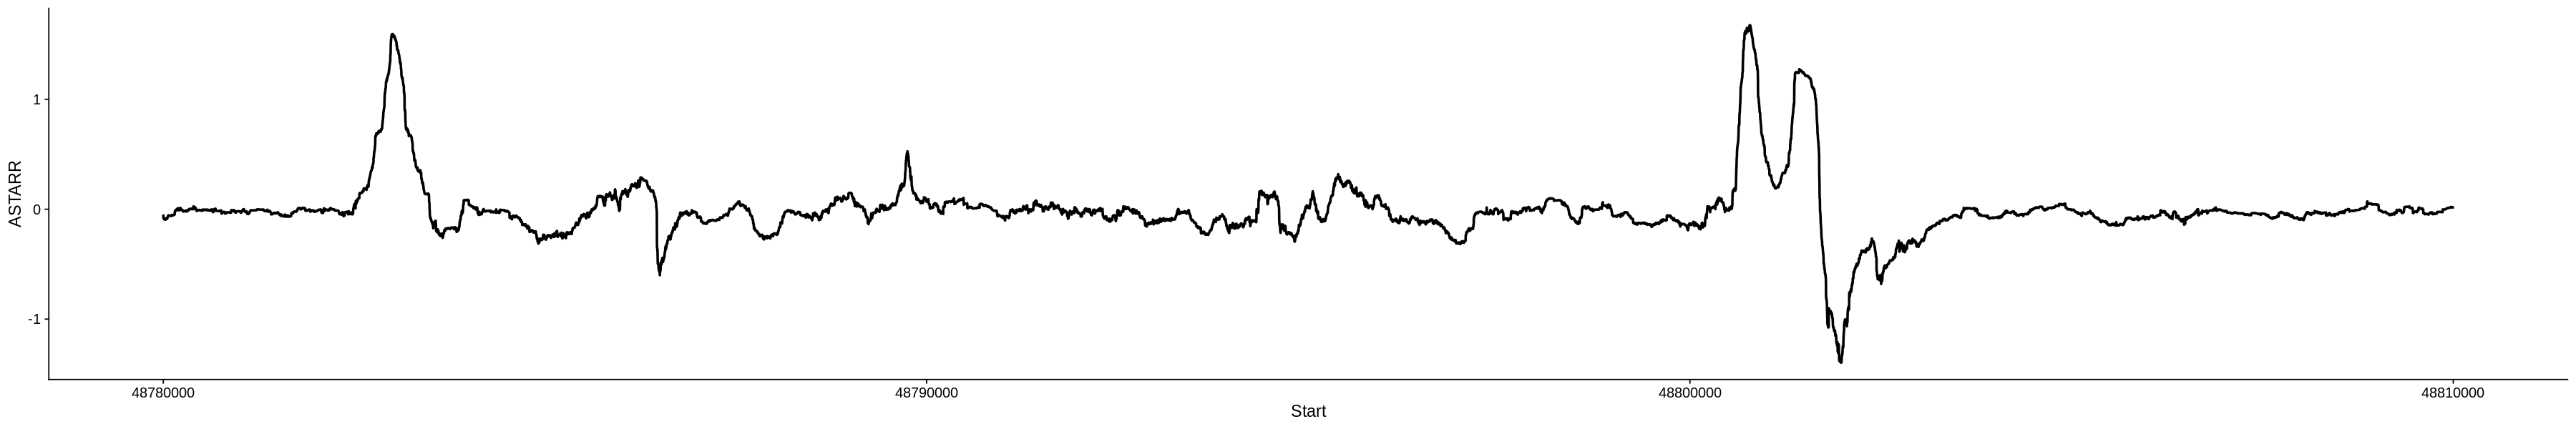

In [70]:
dat = dat_track_sub
gpt = ggplot(dat, aes(x=Start, y=ASTARR)) + geom_line(linewidth=1) + theme_cowplot()

options(repr.plot.height=5, repr.plot.width=30)
print(gpt)

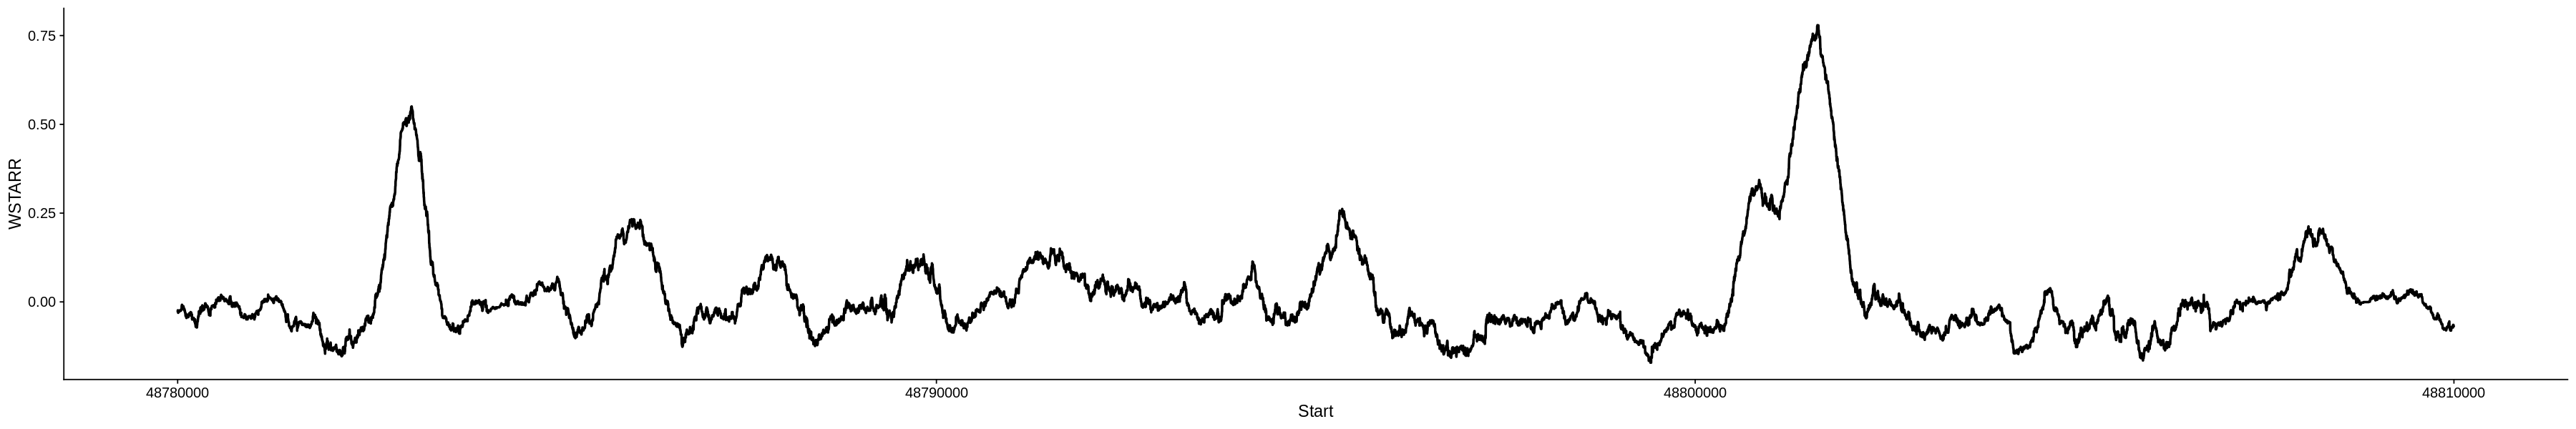

In [71]:
dat = dat_track_sub
gpt = ggplot(dat, aes(x=Start, y=WSTARR)) + geom_line(linewidth=1) + theme_cowplot()

options(repr.plot.height=5, repr.plot.width=30)
print(gpt)

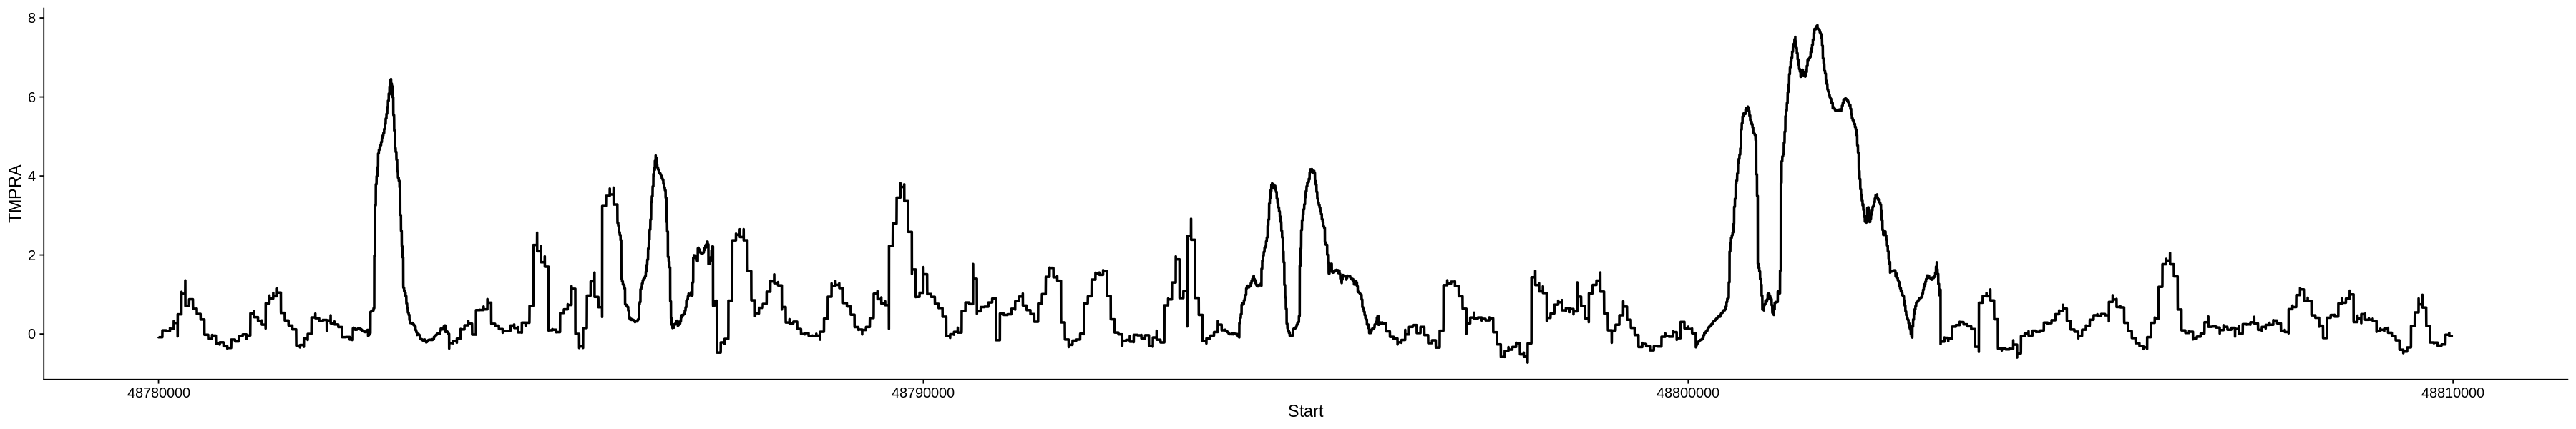

In [72]:
dat = dat_track_sub
gpt = ggplot(dat, aes(x=Start, y=TMPRA)) + geom_line(linewidth=1) + theme_cowplot()

options(repr.plot.height=5, repr.plot.width=30)
print(gpt)

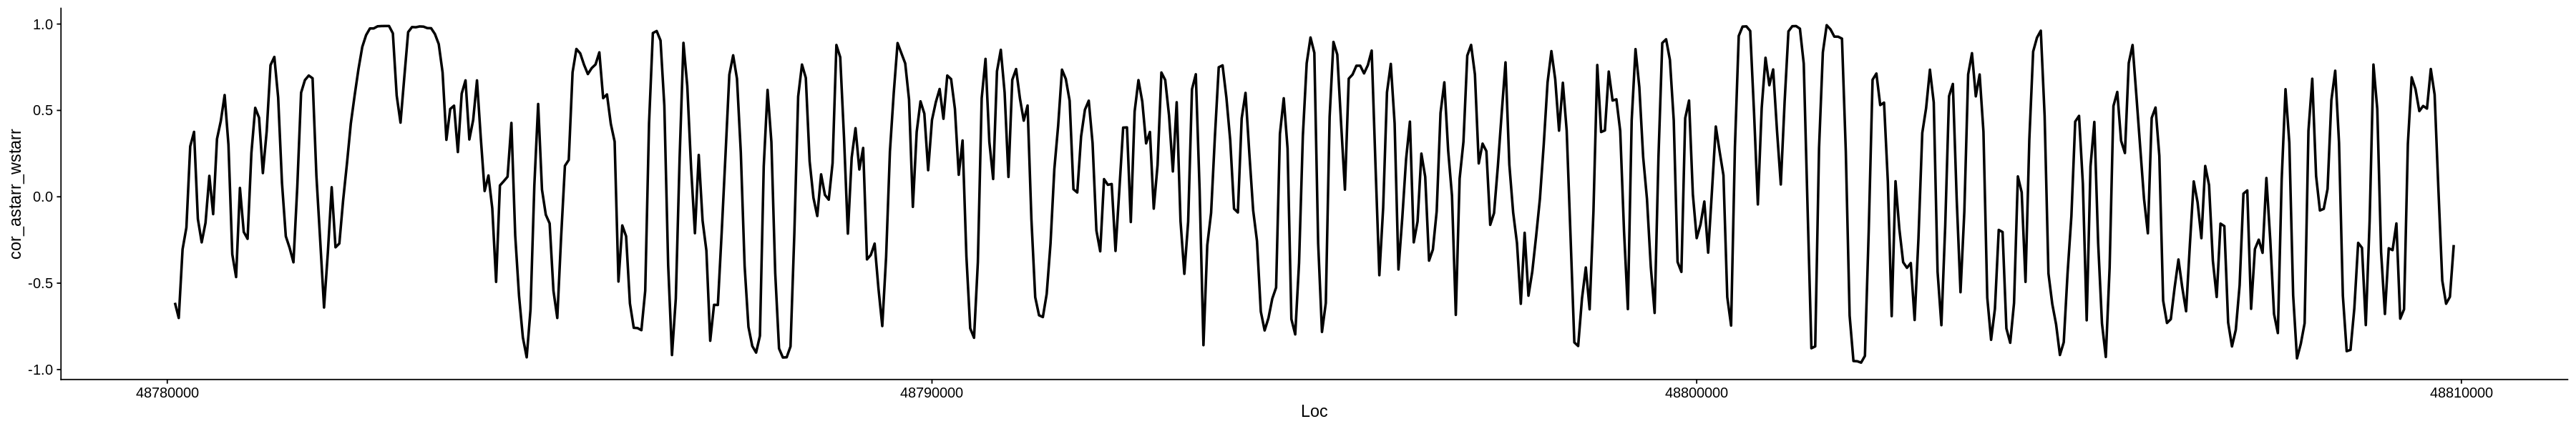

In [73]:
dat = dat_cor
gpt = ggplot(dat, aes(x=Loc, y=cor_astarr_wstarr)) + geom_line(linewidth=1) + theme_cowplot()

options(repr.plot.height=5, repr.plot.width=30)
print(gpt)

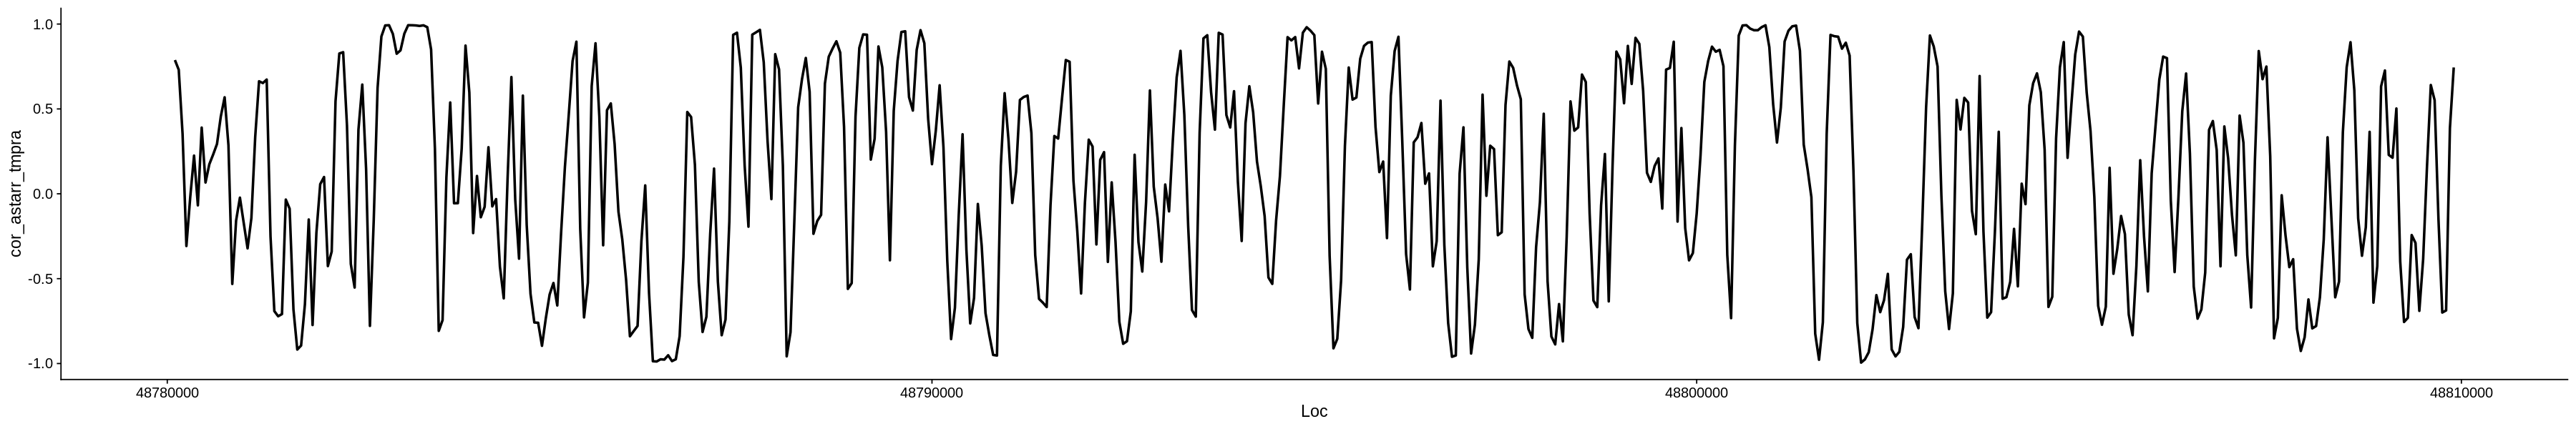

In [74]:
dat = dat_cor
gpt = ggplot(dat, aes(x=Loc, y=cor_astarr_tmpra)) + geom_line(linewidth=1) + theme_cowplot()

options(repr.plot.height=5, repr.plot.width=30)
print(gpt)

In [4]:
dat = as.data.frame(cbind(1:20, 1:20 + 10))
head(dat)

,V1,V2
,<dbl>,<dbl>
1,1,11
2,2,12
3,3,13
4,4,14
5,5,15
6,6,16


In [20]:
N_PARTS =  6
N_ROWS  =  nrow(dat)

idx = sort(1:N_ROWS %% N_PARTS)
lst = split(dat, idx)

In [21]:
print(idx)
table(idx)

 [1] 0 0 0 1 1 1 1 2 2 2 2 3 3 3 4 4 4 5 5 5


idx
0 1 2 3 4 5 
3 4 4 3 3 3 

In [23]:
stringr::str_pad("a", 8, pad = "0")

[1] "0000000a"

In [25]:
1:nrow(dat)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

In [30]:
dat[1,,drop=TRUE]

$V1
[1] 1

$V2
[1] 11

In [33]:
data.frame(1,2,3)

X1,X2,X3
<dbl>,<dbl>,<dbl>
1,2,3


In [34]:
matrix(1,2,3)

1,1,1
1,1,1
